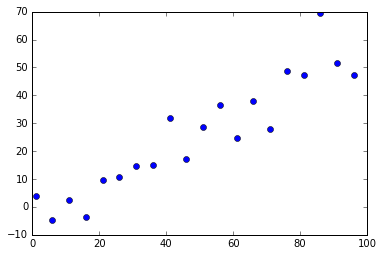

In [1]:
# module import
import pystan
import numpy as np
import pylab as py
import pandas as pd
%matplotlib inline
 
## data simulation
x = np.arange(1, 100, 5)
y = 2.5 + .5 * x + np.random.randn(20) * 10
 
# get number of observations
N = len(x)
 
# plot the data
py.plot(x,y, 'o')
py.show()


In [2]:
# STAN model (this is the most important part)
regress_code = """
data {
 int<lower = 0> N; // number of observations
 real y[N]; // response variable
 real x[N]; // predictor variable
}
parameters {
 real a; // intercept
 real b; // slope
 real<lower=0> sigma; // standard deviation
}
transformed parameters {
 real mu[N]; // fitted values
 
for(i in 1:N)
 mu[i] <- a + b*x[i];
}
model {
 y ~ normal(mu, sigma);
}
"""
 
# make a dictionary containing all data to be passed to STAN
regress_dat = {'x': x,
 'y': y,
 'N': N}
 
# Fit the model
fit = pystan.stan(model_code=regress_code, data=regress_dat,
 iter=5000, chains=4)
 
# model summary
print (fit)

Inference for Stan model: anon_model_f6ebce9f03467a5ca70e280e6b25c124.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       -5.38    0.09   3.85 -13.09   -7.9  -5.32  -2.83   2.12   1652    1.0
b        0.64  1.7e-3   0.07   0.51    0.6   0.64   0.69   0.78   1631    1.0
sigma    8.51    0.04   1.54   6.18   7.41   8.26   9.37  12.14   1845    1.0
mu[0]   -4.74    0.09   3.79  -12.3  -7.21  -4.68  -2.23   2.64   1656    1.0
mu[1]   -1.52    0.09    3.5  -8.53  -3.82  -1.48    0.8   5.32   1683    1.0
mu[2]     1.7    0.08   3.22  -4.74  -0.38   1.73   3.81   8.02   1720    1.0
mu[3]    4.92    0.07   2.95  -0.97   2.99   4.96   6.86  10.75   1773    1.0
mu[4]    8.14    0.06    2.7   2.74    6.4   8.17   9.91  13.48   1848    1.0
mu[5]   11.36    0.06   2.47   6.36   9.76  11.38  12.97  16.26   1957    1.0
mu[6]   14.58    0.05   2.27  

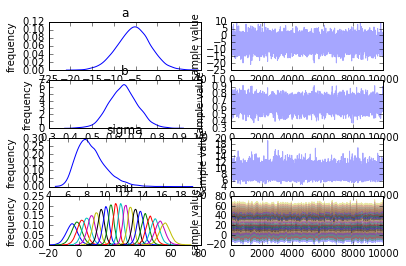

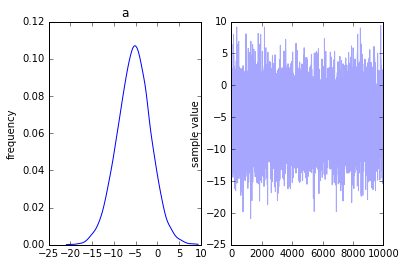

IndexError: index out of bounds

In [3]:
# show a traceplot of ALL parameters. This is a bear if you have many
fit.traceplot()
py.show()
 
# Instead, show a traceplot for single parameter
fit.plot(['a'])
py.show()
 
##### PREDICTION ####
 
# make a dataframe of parameter estimates for all chains
params = pd.DataFrame({'a': fit.extract('a', permuted=True), 'b': fit.extract('b', permuted=True)})
 
# next, make a prediction function. Making a function makes every step following this 10 times easier
def stanPred(p):
 fitted = p[0] + p[1] * predX
 return pd.Series({'fitted': fitted})
 
# make a prediction vector (the values of X for which you want to predict)
predX = np.arange(1, 100)
 
# get the median parameter estimates
medParam = params.median()
# predict
yhat = stanPred(medParam)
 
# get the predicted values for each chain. This is super convenient in pandas because
# it is possible to have a single column where each element is a list
chainPreds = params.apply(stanPred, axis = 1)
 
## PLOTTING
 
# create a random index for chain sampling
idx = np.random.choice(1999, 50)
# plot each chain. chainPreds.iloc[i, 0] gets predicted values from the ith set of parameter estimates
for i in range(len(idx)):
 py.plot(predX, chainPreds.iloc[idx[i], 0], color='lightgrey')
 
# original data
py.plot(x, y, 'ko')
# fitted values
py.plot(predX, yhat['fitted'], 'k')
 
# supplementals
py.xlabel('X')
py.ylabel('Y')
 
py.show()